# Семинар 7 (part2): Metric learning

Задание:

В этой домашней работе вам предстоит решить задачу ассоциации изображений методами metric learning. Необходимо обучить нейронную сеть для поиска похожих автомобилей из датасета cars196. Учтите, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта (не используем метод прямой классификации). Пример формирования предсказаний можно найти в ноутбуке: [metric_learning.ipynb](metric_learning.ipynb) блок Faiss

В процессе решения нужно решить пункты:
1. Реализовать метрики: Precision@k, Recall@k, mAP (1 балл)
2. Добавить train аугментации (1 балл)
3. Обучить модель (2 балла)
   * При обучении использовать backbone отличный от того, что использовался на семинаре (не ResNet50)
   * Добавить triplet-loss (помните о грамотном формировании триплетов)
   * Рассчитать метрики из п.1
4. Показать с помощью GradCAM, где ошибается модель (1 балл)

#### Решение

In [27]:
!python3.9 -m pip install pytorch_metric_learning
!python3.9 -m pip install faiss-cpu
!python3.9 -m pip install lightning

In [28]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cpu'

$\text{Recall}@k = \frac{\text{Number of relevant items in top-}k \text{ results}}{ \text{Total number of relevant items}}$ (Полнота)

In [29]:
def recall_at_k(y_true, y_pred, k=10):
    if len(y_pred) > k:
        y_pred = y_pred[:k]

    relevant = sum(y_true[y_pred])
    total_relevant = sum(y_true)

    if total_relevant == 0:
        return 0.0
    
    return relevant / total_relevant

$\text{Precision}@k = \frac{\text{Number of relevant items in top-}k \text{ results}}{k}$ (Точность)

In [30]:
def precision_at_k(y_true, y_pred, k=10):
    if len(y_pred) > k:
        y_pred = y_pred[:k]

    relevant = sum(y_true[y_pred])
    
    return relevant / len(y_pred)

$\text{mAP} = \frac{1}{Q} \sum_{q=1}^{Q} \text{AP}(q)$

$\text{AP} = \frac{1}{\text{Total relevant items}} \sum_{k=1}^{n} \text{Precision}@k \times \text{rel}(k)$

In [31]:
def average_precision(y_true, y_pred):
    relevant_positions = []
    relevant_count = 0
    
    for i, pred in enumerate(y_pred):
        if y_true[pred]:
            relevant_count += 1
            relevant_positions.append(relevant_count / (i + 1))
    
    if not relevant_positions:
        return 0.0
    
    return sum(relevant_positions) / len(relevant_positions)

def mean_average_precision(all_y_true, all_y_pred):
    aps = []
    
    for y_true, y_pred in zip(all_y_true, all_y_pred):
        ap = average_precision(y_true, y_pred)
        aps.append(ap)
    
    return sum(aps) / len(aps)

Вычисление метрик

In [74]:
import numpy as np

def calculate_metrics_for_faiss(index, query_embeddings, query_labels, gallery_labels, k_values=[1, 5, 10]):
    k_max = max(k_values)
    distances, indices = index.search(query_embeddings, k_max)
    
    all_precisions = {k: [] for k in k_values}
    all_recalls = {k: [] for k in k_values}
    all_y_true = []
    all_y_pred = []
    
    for i, (query_label, neighbor_indices) in enumerate(zip(query_labels, indices)):
        y_true = (gallery_labels[neighbor_indices] == query_label).astype(int)
        y_pred = list(range(len(neighbor_indices)))
        
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

        for k in k_values:
            prec = precision_at_k(y_true, y_pred, k)
            rec = recall_at_k(y_true, y_pred, k)
            all_precisions[k].append(prec)
            all_recalls[k].append(rec)
    
    results = {}
    for k in k_values:
        results[f'P@{k}'] = np.mean(all_precisions[k])
        results[f'R@{k}'] = np.mean(all_recalls[k])
    
    results['mAP'] = mean_average_precision(all_y_true, all_y_pred)
    return results

Аугментации

In [37]:
import torchvision

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Обновление датасетов с аугментациями

In [38]:
ADD_PATH = './cars_train'

In [ ]:
import torch

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

 Функция для получения эмбеддингов

In [ ]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in loader:
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

Модель с Triplet Loss

In [ ]:
import scipy.io

mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [ ]:
import torch.nn as nn
from pytorch_metric_learning import losses, miners, distances
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchvision.models import efficientnet_b0
import faiss


class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.emb_size = emb_size
        
        # backbone: resnet50 -> efficientnet
        self.model = efficientnet_b0(pretrained=True)
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=in_features, out_features=emb_size),
            nn.BatchNorm1d(emb_size)
        )
        
        # Triplet Loss
        self.distance = distances.CosineSimilarity()
        self.miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")
        self.triplet_loss = losses.TripletMarginLoss(margin=0.2)
        
        # ArcFace Loss
        self.arcface_loss = losses.ArcFaceLoss(len(class_dict), emb_size, margin=28.6, scale=64)
        
        # веса для комбинирования лоссов
        self.loss_weight_triplet = 0.6
        self.loss_weight_arcface = 0.4
        
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        
        embeddings = self.model(images)
        
        triplets = self.miner(embeddings, labels)
        
        triplet_loss = self.triplet_loss(embeddings, labels, triplets)
        
        arcface_loss = self.arcface_loss(embeddings, labels)
        
        final_loss = (self.loss_weight_triplet * triplet_loss + 
                     self.loss_weight_arcface * arcface_loss)
        
        self.log("train_triplet_loss", triplet_loss, sync_dist=True)
        self.log("train_arcface_loss", arcface_loss, sync_dist=True)
        self.log("train_total_loss", final_loss, sync_dist=True)
        
        return final_loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        
        embeddings = self.model(images)
        val_loss = self.arcface_loss(embeddings, labels)
        
        self.log("validation_loss", val_loss, sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            embeddings = self.model(images) 
        else:
            embeddings = self.model(images.unsqueeze(0))
        return embeddings
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

Создание датасетов и даталоадеров

In [55]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

In [56]:
train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

In [57]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Обучение модели

In [58]:
# model
pl_model = CarEmbedder(id_to_car, 3e-4, 512)

checkpoint_callback = ModelCheckpoint(monitor='validation_loss', mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=5)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(
    max_epochs=20, 
    accelerator=device, 
    devices=1,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [59]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)


  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | EfficientNet       | 4.7 M  | train
1 | distance     | CosineSimilarity   | 0      | train
2 | miner        | TripletMarginMiner | 0      | train
3 | triplet_loss | TripletMarginLoss  | 0      | train
4 | arcface_loss | ArcFaceLoss        | 100 K  | train
------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.059    Total estimated model params size (MB)
348       Modules in train mode
0         Modules in eval mode


Epoch 19:  29%|██▊       | 58/203 [02:21<05:52,  0.41it/s, v_num=5] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 0: 100%|██████████| 203/203 [4:22:25<00:00,  0.01it/s, v_num=4]


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [70]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 51/51 [00:51<00:00,  1.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss        41.821205139160156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 41.821205139160156}]

Расчет метрик после обучения

In [75]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

# создание faiss индекса
index = faiss.IndexFlatIP(train_emb.shape[1])
faiss.normalize_L2(train_emb)
index.add(train_emb)

metrics = calculate_metrics_for_faiss(index, val_emb, val_labels, train_labels, k_values=[1, 5, 10])

print("\nРЕЗУЛЬТАТЫ МЕТРИК:\n")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")


РЕЗУЛЬТАТЫ МЕТРИК:

P@1: 0.1983
R@1: 0.1201
P@5: 0.1218
R@5: 0.3410
P@10: 0.0982
R@10: 0.5476
mAP: 0.2638


##### GradCAM анализ ошибок модели

In [62]:
!python3.9 -m pip install grad-cam

     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     -------- ------------------------------- 1.6/7.8 MB 10.5 MB/s eta 0:00:01
     ------------------ --------------------- 3.7/7.8 MB 10.9 MB/s eta 0:00:01
     ------------------------------ --------- 6.0/7.8 MB 10.5 MB/s eta 0:00:01
     ------------------------------------ --- 7.1/7.8 MB 8.7 MB/s eta 0:00:01
     ---------------------------------------- 7.8/7.8 MB 8.6 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44339 sha256=001baa15be51f7396b4d62a56e32d64cb69c963cfaa4b3e766684b245754f457
  Stored in directory: c:\users\user\appdata\local\pip\

In [ ]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

Функция для конвертации тензора в изображение

In [64]:
def tensor_to_rgb(tensor):
    inverse_normalize = torchvision.transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inverse_normalize(tensor).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)
    return image

Класс для анализа сходства с классом

In [78]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

Поиск ошибок модели

In [76]:
val_emb, val_labels = get_embeds(pl_model, valid_loader)

# поиск ближайших соседей
Distances, Indexes = index.search(val_emb, 1)
pred_labels = train_labels[Indexes.flatten()]

# поиск индексов ошибок
error_indices = np.where(val_labels != pred_labels)[0]
print(f"Найдено ошибок: {len(error_indices)}")

# берутся первые 3 ошибки для анализа
error_indices = error_indices[:3]

Найдено ошибок: 1306


Анализируем каждую ошибку с GradCAM


Анализ ошибки 1:
Истинный класс: Porsche Panamera Sedan 2012 (id: 172)
Предсказанный класс: Toyota Corolla Sedan 2012 (id: 187)


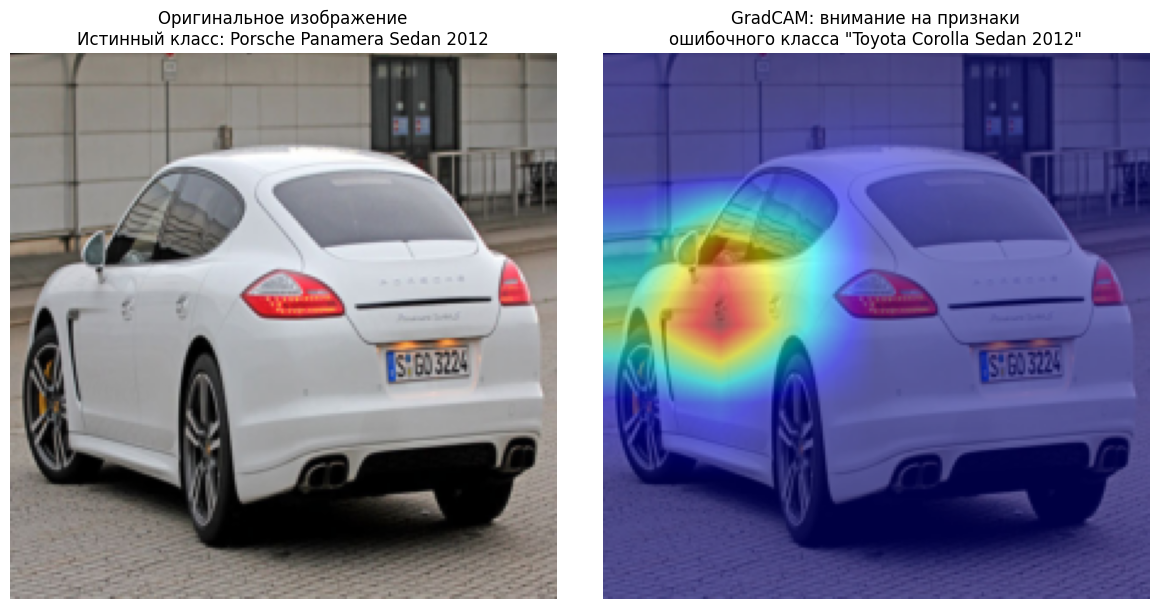


Анализ ошибки 2:
Истинный класс: Dodge Caliber Wagon 2007 (id: 83)
Предсказанный класс: Buick Rainier SUV 2007 (id: 47)


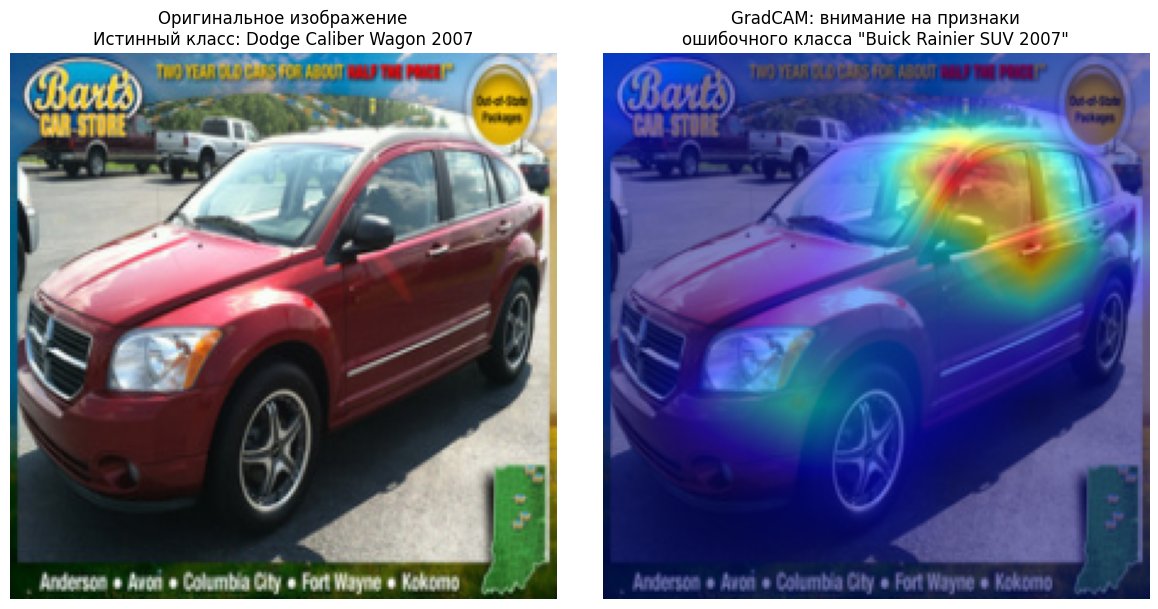


Анализ ошибки 3:
Истинный класс: Chevrolet Express Van 2007 (id: 70)
Предсказанный класс: Dodge Sprinter Cargo Van 2009 (id: 87)


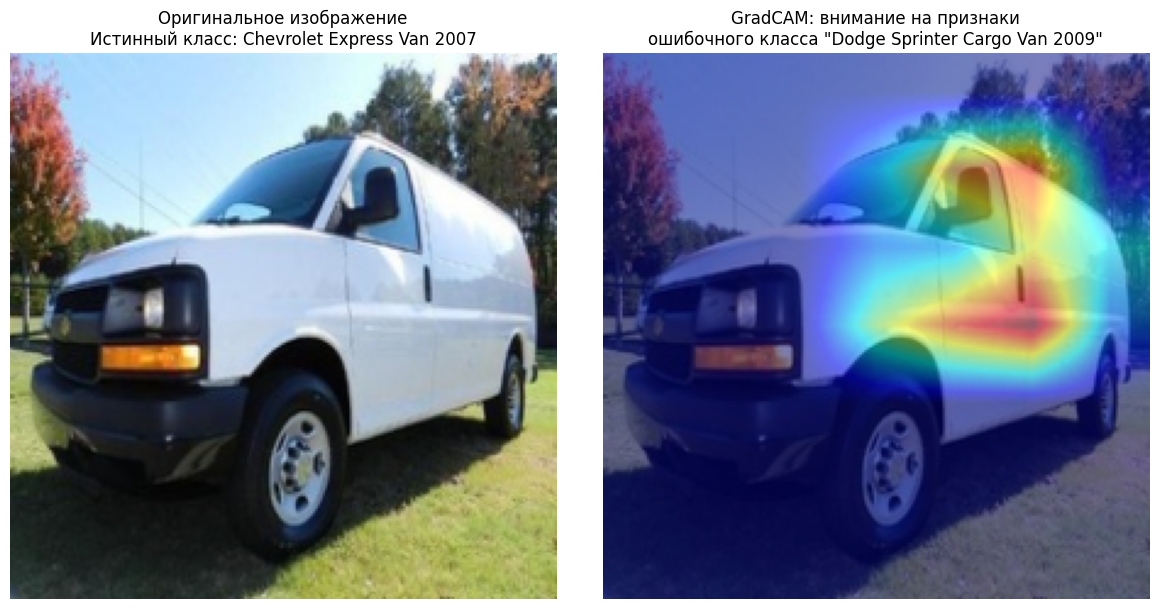

In [79]:
for i, error_idx in enumerate(error_indices):
    print(f"\nАнализ ошибки {i+1}:")
    
    # получение батча с ошибкой
    error_batch = [val_dataset[error_idx]]
    error_loader = DataLoader(error_batch, batch_size=1, shuffle=False)
    
    for batch in error_loader:
        error_image = batch['image']
        true_label = batch['label'].item()
        pred_label = pred_labels[error_idx]
        
        print(f"Истинный класс: {id_to_car[true_label]} (id: {true_label})")
        print(f"Предсказанный класс: {id_to_car[pred_label]} (id: {pred_label})")
        
        # эмбеддинг ошибочного изображения
        with torch.no_grad():
            error_embedding = pl_model(error_image)[0, :]
        
        # типичный эмбеддинг ошибочного класса
        wrong_class_embeddings = train_emb[train_labels == pred_label]
        if len(wrong_class_embeddings) > 0:
            typical_wrong_embedding = torch.tensor(wrong_class_embeddings[0]).to(device)
        else:
            print("Не найдено примеров ошибочного класса")
            continue
        
        wrong_target = [SimilarityToConceptTarget(typical_wrong_embedding)]
        target_layers = [pl_model.model.features[-1]]
        
        cam = GradCAM(model=pl_model.model, target_layers=target_layers)
        # получение GradCAM карты
        grayscale_cam = cam(input_tensor=error_image, targets=wrong_target)[0, :]
        
        rgb_image = tensor_to_rgb(error_image[0])
        
        # наложение GradCAM на изображение
        cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        
        # визуализация
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(rgb_image)
        axes[0].set_title(f'Оригинальное изображение\nИстинный класс: {id_to_car[true_label]}')
        axes[0].axis('off')
        
        axes[1].imshow(cam_image)
        axes[1].set_title(f'GradCAM: внимание на признаки\nошибочного класса "{id_to_car[pred_label]}"')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

Анализ сходства с правильным классом


Анализ ошибки 1:


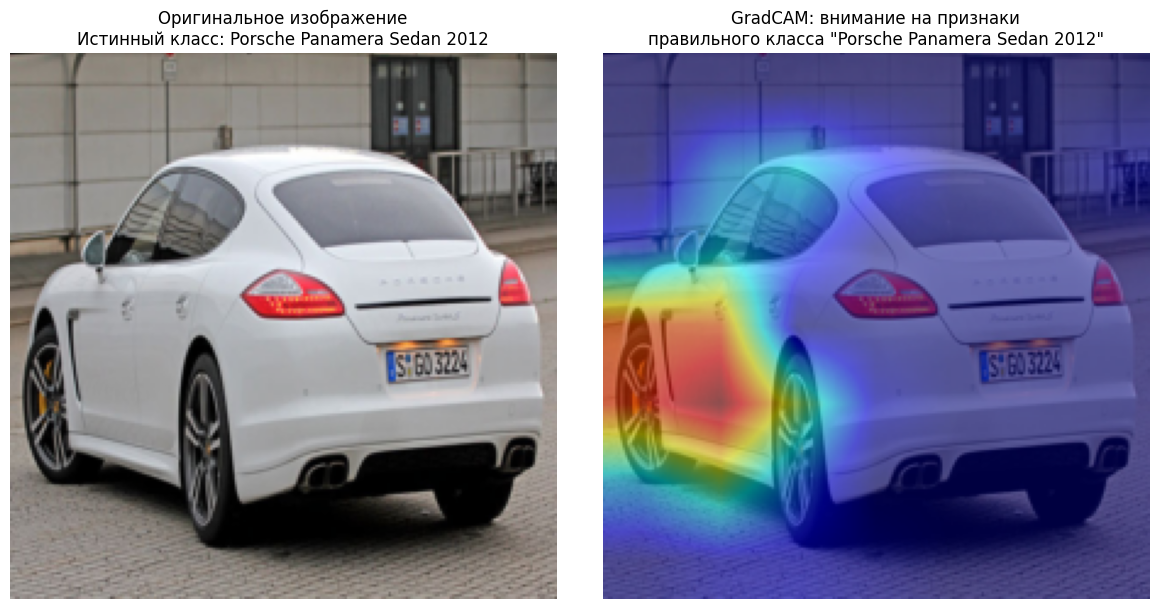


Анализ ошибки 2:


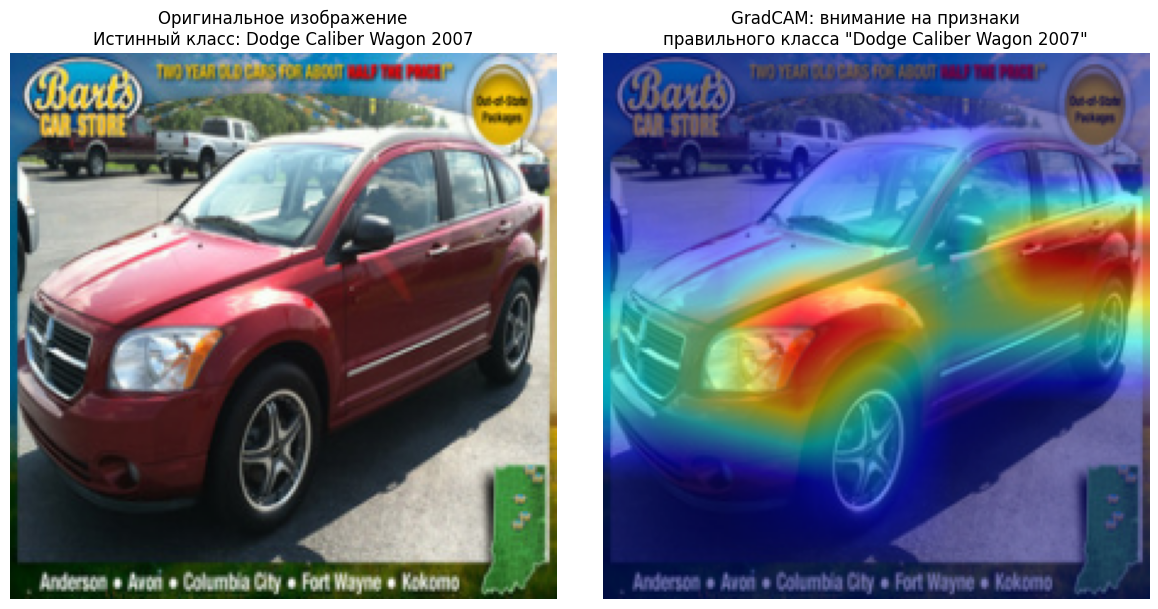


Анализ ошибки 3:


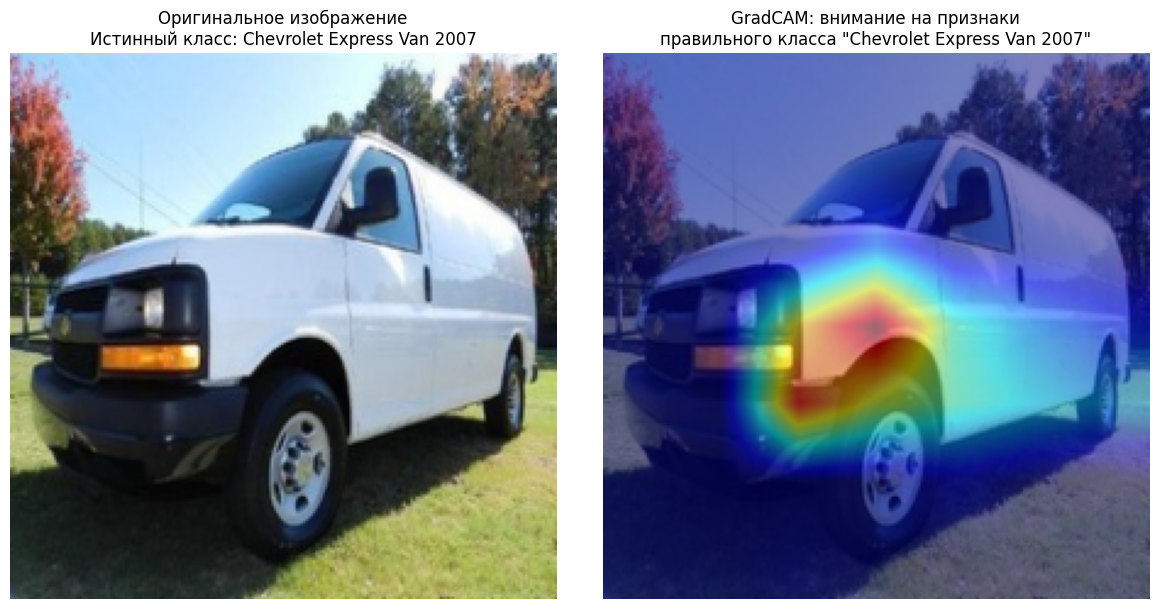

In [80]:
for i, error_idx in enumerate(error_indices):
    print(f"\nАнализ ошибки {i+1}:")
    
    # получение батча с ошибкой
    error_batch = [val_dataset[error_idx]]
    error_loader = DataLoader(error_batch, batch_size=1, shuffle=False)
    
    for batch in error_loader:
        error_image = batch['image']
        true_label = batch['label'].item()
        pred_label = pred_labels[error_idx]
        
        # типичный эмбеддинг правильного класса
        true_class_embeddings = train_emb[train_labels == true_label]
        if len(true_class_embeddings) > 0:
            typical_true_embedding = torch.tensor(true_class_embeddings[0]).to(device)
        else:
            continue
        
        true_target = [SimilarityToConceptTarget(typical_true_embedding)]
        target_layers = [pl_model.model.features[-1]]
        
        cam = GradCAM(model=pl_model.model, target_layers=target_layers)
        # получение GradCAM карты
        grayscale_cam = cam(input_tensor=error_image, targets=true_target)[0, :]
        
        rgb_image = tensor_to_rgb(error_image[0])
        
        # наложение GradCAM на изображение
        cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        
        # визуализация
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(rgb_image)
        axes[0].set_title(f'Оригинальное изображение\nИстинный класс: {id_to_car[true_label]}')
        axes[0].axis('off')
        
        axes[1].imshow(cam_image)
        axes[1].set_title(f'GradCAM: внимание на признаки\nправильного класса "{id_to_car[true_label]}"')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()